In [75]:
# add module to path so we can import it
import sys
sys.path.append('../breast_segment')
from breast_segment import breast_segment

In [54]:
# We'll need some helper functions to open the
# weird ddsm images. Good news! I've already written them.
# You will have to put them on your python path, simply replace
# the path below with the location where these modules reside.

# get the modules from here:
# https://github.com/olieidel/ljpeg3
# https://github.com/olieidel/ddsmtools

# uncomment these lines and fill in the paths
#sys.path.append('PATH_TO_LJPEG3')
#sys.path.append('PATH_TO_DDSMTOOLS')

# Here, this is how I do it (you better comment these lines out)
sys.path.append('../../ljpeg3')
sys.path.append('../../ddsmtools')

In [82]:
# If you've done everything correctly, this should work

from ljpeg3 import ljpeg
from ddsmtools import ics, overlay, visualize

In [51]:
# Let's download some mammographies!
# To save you some time, I wrote a simple ftp downloader
# for the DDSM database (http://marathon.csee.usf.edu/Mammography/Database.html)
# No need to understand this, just skip it

def ddsm_download(classification='normals', collection='normal_01', case='case0022'):
    from ftplib import FTP
    import os
    ftp = FTP('figment.csee.usf.edu') 
    ftp.login('anonymous', '')
    ftp.cwd('/pub/DDSM/cases/{}/{}/{}/'.format(classification, collection, case))
    file_list = []
    ftp.retrlines('LIST', lambda x: file_list.append(x.split()))
    for info in file_list:
        ls_type, name = info[0], info[-1]
        if not ls_type.startswith('d'):
            file_dir = os.path.join(os.getcwd(), 'files', case, name)
            os.makedirs(os.path.dirname(file_dir), exist_ok=True)
            with open(file_dir, 'wb') as f:
                ftp.retrbinary('RETR {}'.format(name), f.write)
    ftp.close()

In [112]:
# start the download
ddsm_download('normals', 'normal_09', 'case3600')

In [114]:
# Now, we can open our freshly loaded files.
# Don't get distracted by some weird messages, it's "normal"

im_file = 'B_3600_1.LEFT_CC.LJPEG'
im_path = os.path.join(os.getcwd(), 'files', 'case3600', im_file)
im = ljpeg.read(im_path)

# let's also open the .ics file, just because we can
ics_file = ics.ics_file_name(im_path)
ics_data = ics.parse_ics(os.path.join('files', 'case3600', ics_file))

found ics file
/Users/oli/Coding/python/breast_segment/examples/files/case3600/B-3600-1.ics


In [68]:
# you will need matplotlib: pip3 install matplotlib
# sorry for the inconvenience
from matplotlib import pyplot as plt
%matplotlib inline

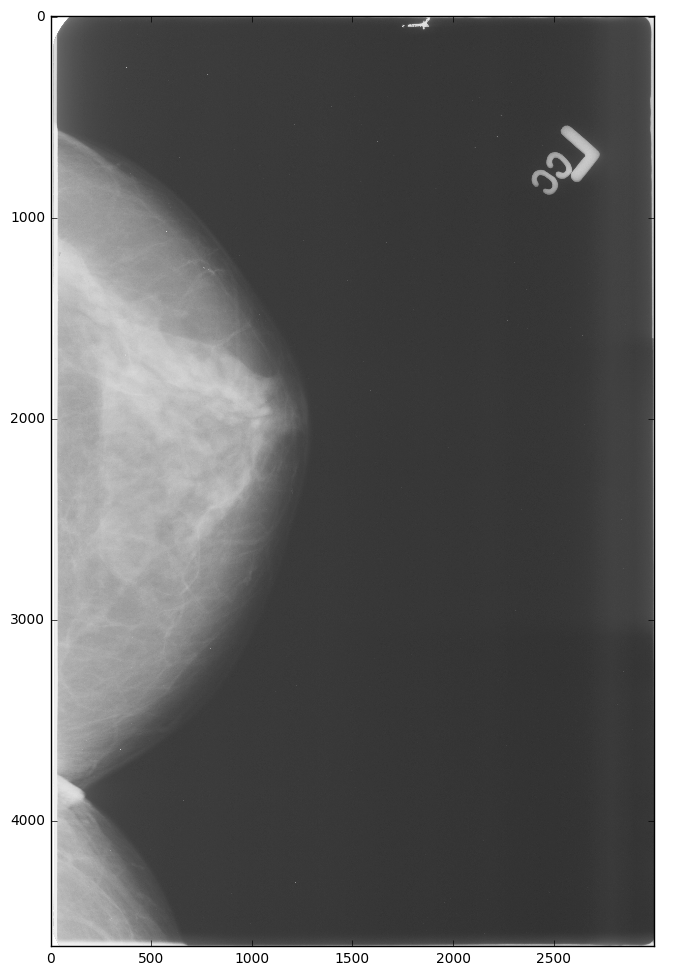

In [144]:
# let's take a look!
f, ax = plt.subplots(1, figsize=(12, 12)) # adjust the figure size
# set the correct window and color map.
# radiologists like gray, not understandably
ax.imshow(im, vmin=0, vmax=4096, cmap='gray')

(array([ 9627427.,  1034735.,   282354.,   262327.,   394495.,   735979.,
         1010529.,   353107.,    38768.,   132279.]),
 array([  738. ,  1073.7,  1409.4,  1745.1,  2080.8,  2416.5,  2752.2,
         3087.9,  3423.6,  3759.3,  4095. ]),
 <a list of 10 Patch objects>)

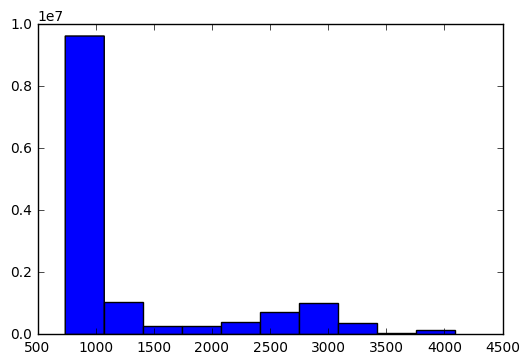

In [117]:
# let's just quickly check the histogram of the
# image values as some images in DDSM are really
# weird (this one looks okay)
plt.hist(im.ravel())

In [118]:
# finally! let's do some segmentation!
mask, bbox = breast_segment(im)

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


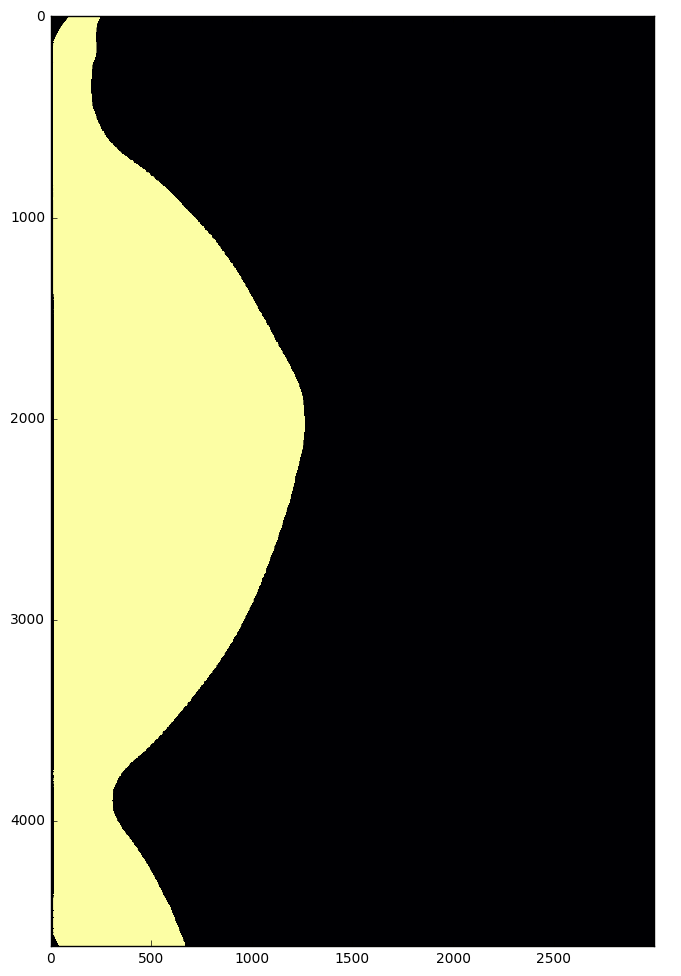

In [143]:
# let's check..
# wow! it worked!
# confession: it doesn't always work that well
f, ax = plt.subplots(1, figsize=(12, 12)) # adjust the figure size
# set the correct window and color map.
# radiologists like gray, not understandably
ax.imshow(mask, vmin=0, vmax=1, cmap='inferno') # use inferno colormap for dramatisation

In [121]:
# for further processing, the bbox variable gives
# us coordinates of a rectangular bounding box of the segmentation
# in the format:
# (minimum_row, minimum_column, maximum_row, maximum_column)
bbox

(0, 10, 4623, 1261)

In [125]:
# we're actually done, but just for some fun, let's
# have a look how we can better visualize this

# prepare the bbox for visalization
def bbox_lines(im, bbox):
    # destructure the bbox as into columns and rows, see above
    minr, minc, maxr, maxc = bbox
    line_left = mlines.Line2D([minc, minc], [0, im.shape[0]], color='y', lw=2, alpha=.5)
    line_right = mlines.Line2D([maxc, maxc], [0, im.shape[0]], color='y', lw=2, alpha=.5)
    line_top = mlines.Line2D([0, im.shape[1]], [minr, minr], color='y', lw=2, alpha=.5)
    line_bot = mlines.Line2D([0, im.shape[1]], [maxr, maxr], color='y', lw=2, alpha=.5)
    
    return line_left, line_right, line_top, line_bot

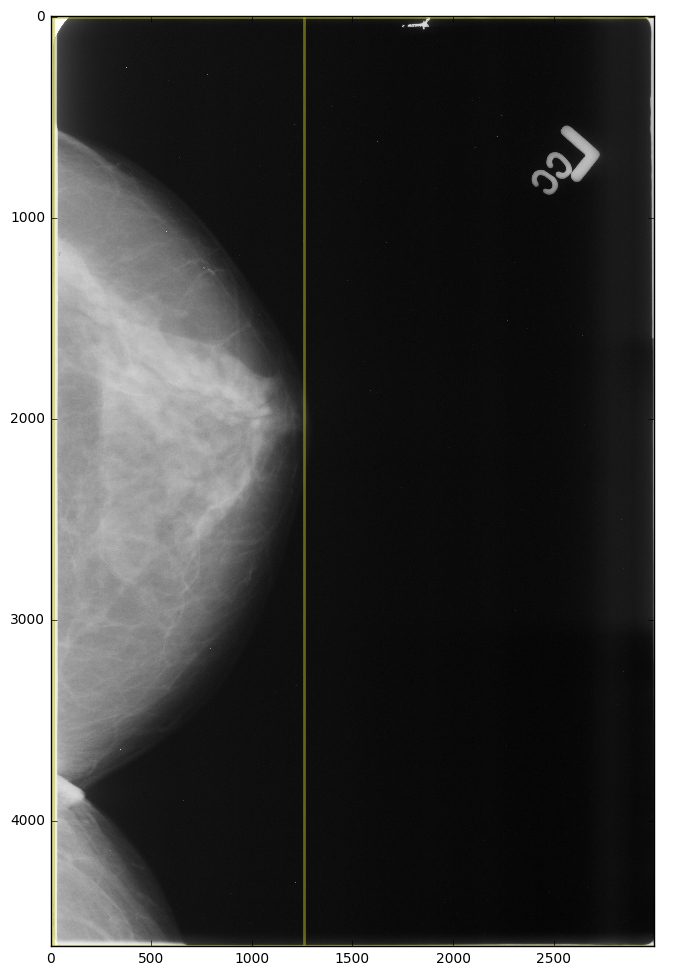

In [128]:
# let's plot it! .. in yellow

import matplotlib.lines as mlines

f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(im, cmap='gray')
lines = bbox_lines(im, bbox)
[ax.add_line(l) for l in lines]

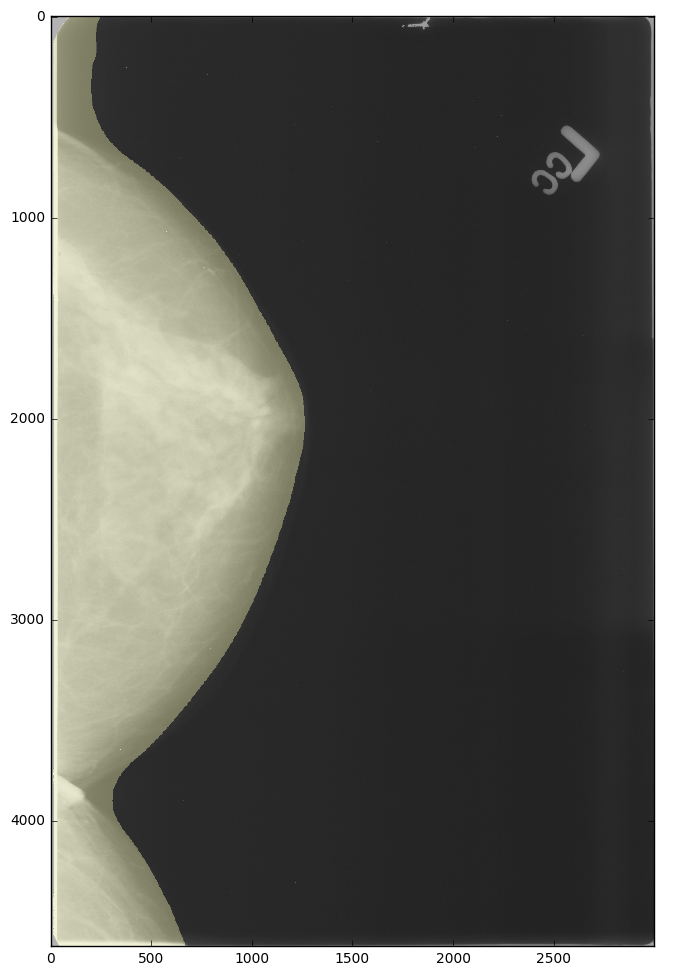

In [142]:
# one last thing: how about an overlay?
f = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.imshow(im, vmin=0, vmax=4096, cmap='gray')
ax.imshow(mask, alpha=.3, cmap='inferno') # alpha controls the transparency